## Baseline CNN with CT dataset on kaggle
- Softmax

### dataset
[1] CT Medical Images, https://www.kaggle.com/kmader/siim-medical-images

In [1]:
import numpy as np # matrix tools
import matplotlib.pyplot as plt # for basic plots
import seaborn as sns # for nicer plots
import pandas as pd
from glob import glob
import re
from skimage.io import imread

import keras

Using TensorFlow backend.


In [2]:
overview_df = pd.read_csv('../input/overview.csv')
overview_df.columns = ['idx']+list(overview_df.columns[1:])
overview_df['Contrast'] = overview_df['Contrast'].map(lambda x: 'Contrast' if x else 'No Contrast')
overview_df.sample(3)

,idx,Age,Contrast,ContrastTag,raw_input_path,id,tiff_name,dicom_name
19,19,70,Contrast,NONE,../data/50_50_dicom_cases\Contrast\00001 (27).dcm,19,ID_0019_AGE_0070_CONTRAST_1_CT.tif,ID_0019_AGE_0070_CONTRAST_1_CT.dcm
71,71,65,No Contrast,NONE,../data/50_50_dicom_cases\No contrast\000001 (...,71,ID_0071_AGE_0065_CONTRAST_0_CT.tif,ID_0071_AGE_0065_CONTRAST_0_CT.dcm
48,48,77,Contrast,NONE,../data/50_50_dicom_cases\Contrast\00001 (8).dcm,48,ID_0048_AGE_0077_CONTRAST_1_CT.tif,ID_0048_AGE_0077_CONTRAST_1_CT.dcm


In [3]:
%matplotlib inline
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname,"______")
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input ______
/kaggle/input/full_archive.npz
/kaggle/input/overview.csv
/kaggle/input/dicom_dir ______
/kaggle/input/dicom_dir/ID_0015_AGE_0061_CONTRAST_1_CT.dcm
/kaggle/input/dicom_dir/ID_0019_AGE_0070_CONTRAST_1_CT.dcm
/kaggle/input/dicom_dir/ID_0063_AGE_0073_CONTRAST_0_CT.dcm
/kaggle/input/dicom_dir/ID_0077_AGE_0074_CONTRAST_0_CT.dcm
/kaggle/input/dicom_dir/ID_0073_AGE_0074_CONTRAST_0_CT.dcm
/kaggle/input/dicom_dir/ID_0060_AGE_0080_CONTRAST_0_CT.dcm
/kaggle/input/dicom_dir/ID_0051_AGE_0063_CONTRAST_0_CT.dcm
/kaggle/input/dicom_dir/ID_0091_AGE_0072_CONTRAST_0_CT.dcm
/kaggle/input/dicom_dir/ID_0004_AGE_0056_CONTRAST_1_CT.dcm
/kaggle/input/dicom_dir/ID_0076_AGE_0068_CONTRAST_0_CT.dcm
/kaggle/input/dicom_dir/ID_0055_AGE_0071_CONTRAST_0_CT.dcm
/kaggle/input/dicom_dir/ID_0000_AGE_0060_CONTRAST_1_CT.dcm
/kaggle/input/dicom_dir/ID_0089_AGE_0071_CONTRAST_0_CT.dcm
/kaggle/input/dicom_dir/ID_0036_AGE_0074_CONTRAST_1_CT.dcm
/kaggle/input/dicom_dir/ID_0066_AGE_0082_CONTRAST_0_CT.dcm
/kagg

In [4]:
IS_LOCAL = False
if(IS_LOCAL):
    PATH="../input/siim-medical-image/"
else:
    PATH="../input/"
print(os.listdir(PATH))
overview = pd.read_csv(os.path.join(PATH,"overview.csv"))
overview.head()

['dicom_dir', 'full_archive.npz', 'tiff_images', 'overview.csv']


,Unnamed: 0,Age,Contrast,ContrastTag,raw_input_path,id,tiff_name,dicom_name
0,0,60,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (1).dcm,0,ID_0000_AGE_0060_CONTRAST_1_CT.tif,ID_0000_AGE_0060_CONTRAST_1_CT.dcm
1,1,69,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (10).dcm,1,ID_0001_AGE_0069_CONTRAST_1_CT.tif,ID_0001_AGE_0069_CONTRAST_1_CT.dcm
2,2,74,True,APPLIED,../data/50_50_dicom_cases\Contrast\00001 (11).dcm,2,ID_0002_AGE_0074_CONTRAST_1_CT.tif,ID_0002_AGE_0074_CONTRAST_1_CT.dcm
3,3,75,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (12).dcm,3,ID_0003_AGE_0075_CONTRAST_1_CT.tif,ID_0003_AGE_0075_CONTRAST_1_CT.dcm
4,4,56,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (13).dcm,4,ID_0004_AGE_0056_CONTRAST_1_CT.tif,ID_0004_AGE_0056_CONTRAST_1_CT.dcm


In [5]:
len(overview)

100

In [6]:
overview['Contrast'] = overview['Contrast'].map(lambda x: 1 if x else 0)

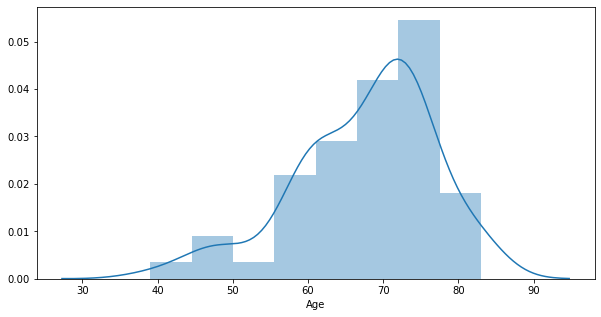

In [7]:
plt.figure(figsize=(10,5))
sns.distplot(overview['Age'])

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


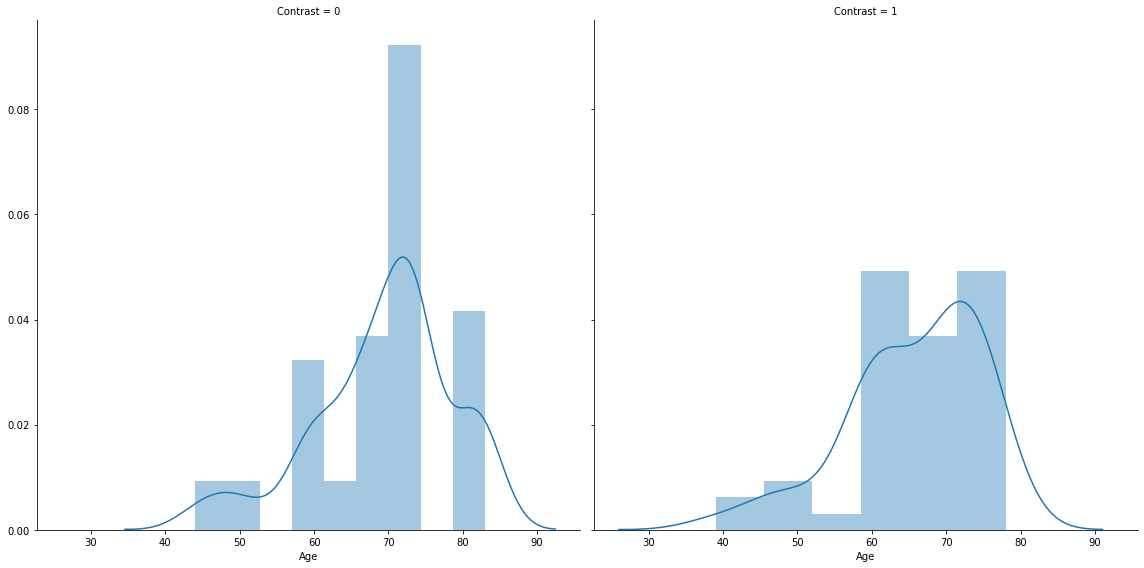

In [8]:
g = sns.FacetGrid(overview, col="Contrast", size=8)
g = g.map(sns.distplot, "Age")

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


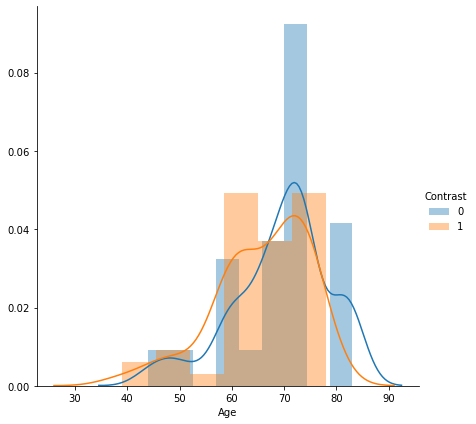

In [9]:
g = sns.FacetGrid(overview, hue="Contrast",size=6, legend_out=True)
g = g.map(sns.distplot, "Age").add_legend()

In [10]:
#if(IS_LOCAL):
   #PATH="/input/siim-medical-image/"
#else:
    #PATH="/input/"


BASE_IMG_PATH='../input'
#print(os.listdir(BASE_IMG_PATH))
#print(os.path.join(BASE_IMG_PATH,'tiff_images','*.tif'))
all_images_list = glob(os.path.join(BASE_IMG_PATH,'tiff_images','*.tif'))
all_images_list[:5]
print(all_images_list)

['../input/tiff_images/ID_0027_AGE_0064_CONTRAST_1_CT.tif', '../input/tiff_images/ID_0096_AGE_0083_CONTRAST_0_CT.tif', '../input/tiff_images/ID_0073_AGE_0074_CONTRAST_0_CT.tif', '../input/tiff_images/ID_0046_AGE_0072_CONTRAST_1_CT.tif', '../input/tiff_images/ID_0052_AGE_0072_CONTRAST_0_CT.tif', '../input/tiff_images/ID_0015_AGE_0061_CONTRAST_1_CT.tif', '../input/tiff_images/ID_0009_AGE_0048_CONTRAST_1_CT.tif', '../input/tiff_images/ID_0048_AGE_0077_CONTRAST_1_CT.tif', '../input/tiff_images/ID_0020_AGE_0066_CONTRAST_1_CT.tif', '../input/tiff_images/ID_0055_AGE_0071_CONTRAST_0_CT.tif', '../input/tiff_images/ID_0077_AGE_0074_CONTRAST_0_CT.tif', '../input/tiff_images/ID_0086_AGE_0073_CONTRAST_0_CT.tif', '../input/tiff_images/ID_0005_AGE_0048_CONTRAST_1_CT.tif', '../input/tiff_images/ID_0050_AGE_0074_CONTRAST_0_CT.tif', '../input/tiff_images/ID_0002_AGE_0074_CONTRAST_1_CT.tif', '../input/tiff_images/ID_0016_AGE_0063_CONTRAST_1_CT.tif', '../input/tiff_images/ID_0083_AGE_0082_CONTRAST_0_CT.ti

In [11]:
imread(all_images_list[0]).shape

(512, 512)

In [12]:
np.array(np.arange(81)).reshape(9,9)

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
       [ 9, 10, 11, 12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23, 24, 25, 26],
       [27, 28, 29, 30, 31, 32, 33, 34, 35],
       [36, 37, 38, 39, 40, 41, 42, 43, 44],
       [45, 46, 47, 48, 49, 50, 51, 52, 53],
       [54, 55, 56, 57, 58, 59, 60, 61, 62],
       [63, 64, 65, 66, 67, 68, 69, 70, 71],
       [72, 73, 74, 75, 76, 77, 78, 79, 80]])

In [13]:
np.array(np.arange(81)).reshape(9,9)[::3,::3]

array([[ 0,  3,  6],
       [27, 30, 33],
       [54, 57, 60]])

In [14]:
np.expand_dims(imread(all_images_list[0])[::4,::4],0).shape

(1, 128, 128)

In [15]:
jimread = lambda x: np.expand_dims(imread(x)[::2,::2],0)

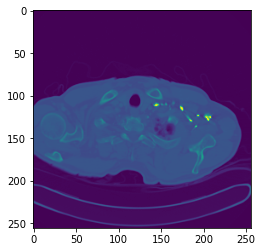

In [16]:
test_image = jimread(all_images_list[0])
plt.imshow(test_image[0])

In [17]:
check_contrast = re.compile(r'ID_([\d]+)_AGE_[\d]+_CONTRAST_([\d]+)_CT')
label = []
id_list = []
for image in all_images_list:
    id_list.append(check_contrast.findall(image)[0][0])
    label.append(check_contrast.findall(image)[0][1])

In [18]:
label_list = pd.DataFrame(label,id_list)

In [19]:
label_list.head()

,0
0027,1
0096,0
0073,0
0046,1
0052,0


In [20]:
images = np.stack([jimread(i) for i in all_images_list],0)

In [21]:
len(images)

100

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(images, label_list, test_size=0.1, random_state=0)

In [24]:
n_train, depth, width, height = X_train.shape
n_test,_,_,_ = X_test.shape

In [25]:
n_train,depth, width, height

(90, 1, 256, 256)

In [26]:
input_shape = (width,height,depth)

In [27]:
input_shape

(256, 256, 1)

In [28]:
input_train = X_train.reshape((n_train, width,height,depth))
input_train.shape
input_train.astype('float32')
input_train = input_train / np.max(input_train)
input_train.max()

1.0

In [29]:
input_test = X_test.reshape(n_test, *input_shape)
input_test.astype('float32')
input_test = input_test / np.max(input_test)

In [30]:
output_train = keras.utils.to_categorical(y_train, 2)
output_test = keras.utils.to_categorical(y_test, 2)
output_train[5]

array([0., 1.], dtype=float32)

In [31]:
input_train.shape

(90, 256, 256, 1)

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D

In [33]:
batch_size = 20
epochs = 40

In [34]:
model2 = Sequential()
model2.add(Conv2D(50, (5, 5), activation='relu', input_shape=input_shape))
 # 32 4x4 Filter  Convolutional Network
model2.add(MaxPooling2D(pool_size=(3, 3))) # 3x3 Maxpooling 
model2.add(Conv2D(30, (4, 4), activation='relu', input_shape=input_shape))
model2.add(MaxPooling2D(pool_size=(2, 2))) # 2x2 Maxpooling 
model2.add(Flatten()) #Fully Connected Neural Network 
model2.add(Dense(2, activation='softmax'))

In [35]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 252, 252, 50)      1300      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 84, 84, 50)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 81, 81, 30)        24030     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 40, 40, 30)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 48000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 96002     
Total params: 121,332
Trainable params: 121,332
Non-trainable params: 0
________________________________________________

In [36]:
model2.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [37]:
history = model2.fit(input_train, output_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(input_test, output_test))

Train on 90 samples, validate on 10 samples
Epoch 1/40
90/90 [==============================] - 6s 67ms/step - loss: 0.7708 - accuracy: 0.5111 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/40
90/90 [==============================] - 5s 60ms/step - loss: 0.6477 - accuracy: 0.5000 - val_loss: 0.6455 - val_accuracy: 0.5000
Epoch 3/40
90/90 [==============================] - 5s 59ms/step - loss: 0.5555 - accuracy: 0.7333 - val_loss: 0.5310 - val_accuracy: 0.8000
Epoch 4/40
90/90 [==============================] - 5s 59ms/step - loss: 0.3783 - accuracy: 0.9222 - val_loss: 0.4751 - val_accuracy: 0.7000
Epoch 5/40
90/90 [==============================] - 6s 62ms/step - loss: 0.2274 - accuracy: 0.9444 - val_loss: 0.3330 - val_accuracy: 0.9000
Epoch 6/40
90/90 [==============================] - 5s 61ms/step - loss: 0.1354 - accuracy: 0.9556 - val_loss: 0.2924 - val_accuracy: 0.9000
Epoch 7/40
90/90 [==============================] - 5s 60ms/step - loss: 0.0761 - accuracy: 0.9778 - val_loss:

In [38]:
score = model2.evaluate(input_test, output_test, verbose=0)
score

[0.2627817690372467, 0.8999999761581421]

In [39]:
model2.predict(input_test)

array([[7.1709186e-01, 2.8290817e-01],
       [1.5007465e-03, 9.9849927e-01],
       [9.9961096e-01, 3.8906775e-04],
       [9.6889067e-01, 3.1109348e-02],
       [1.7599260e-02, 9.8240077e-01],
       [8.6585736e-01, 1.3414262e-01],
       [9.8945576e-01, 1.0544239e-02],
       [8.9240428e-05, 9.9991071e-01],
       [7.9893589e-01, 2.0106411e-01],
       [1.0474736e-11, 1.0000000e+00]], dtype=float32)

## References  
[1] Applyting CNN on CT images with Keras 8c67fd, https://www.kaggle.com/abjorox/applyting-cnn-on-ct-images-with-keras-project-my